<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPI (Message Passing Interface)

* MPI is a mechanism for inter-process communication
* Processes do not share memory
* Instead they send messages to each other to communicate
* MPI is highly scalable, so it can operate on anything from **multiple cores** to **multiple nodes** in a cluster
* It is a lower level library, which means there are more pitfalls / challenges when using it
* However, it has much more flexibility than something like `ProcessPoolExecutor`
* MPI is used widely in
  * Weather models
  * CFD models
  * Finite Elements
  * Numerical Linear Algebra
  * Graph processing
  * Astrophysics

  among many other domains.
> Note that a benefit of MPI is that it can play nicely with NumPy and Numba. Hence, we can divide a task amongst several processes, and do the computation in each task using NumPy or Numba

## mpi4py
* Built on top of the C MPI standard
*  Gives you almost full access to MPI, but it uses Python objects and NumPy arrays
* Inter-process communication can be achieved with
  * Pickle based messaging (sending / receiving Python objects)
  * Buffer based messaging (Writing / reading into NumPy arrays)
* To execute a Python script that uses mpi4py you would use the command
```
mpiexec -n N python script.py
```
* This launches $N$ processes
* Each process has a rank, which acts as its unique identifier $0, \cdots, N-1$
* Each process can access a communicator (usually called `MPI.COMM_WORLD`)
* Processes can communicate point-to-point with other processes
* They can also use collective operations like broadcast, scatter, gather, and reduce


## Minimal Program
Here's how to run a minimal MPI program in a Jupyter notebook. First we'll just install `mpi4py` and mpich. I'm running the notebook in a `.devcontainer` environment. Note, that you'll want to run this notebook locally on a mulitcore machine to use MPI.


In [ ]:
!sudo apt-get update
!pip install mpi4py mpich

This will write a file called `hello_mpi.py` that just has each process say hello.

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
name = MPI.Get_processor_name()
msg = f"Hello from rank {rank}/{size} on {name}"
print(msg)
PY

We can execute it as follows:

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Hello from rank 0/4 on 79cd1347a82a
Hello from rank 3/4 on 79cd1347a82a
Hello from rank 1/4 on 79cd1347a82a
Hello from rank 2/4 on 79cd1347a82a


## Mental Model for MPI
* As a mental model in MPI, every process runs the same code, but the processes rank determines exactly what role that process plays
* Hence, there can be branching code for a specific process using syntax like

```
if rank == 0:
    # Do something
```
* Data is not shared. If process 0 creates a variable, processes $1 \cdots N-1$ don’t see it unless it’s sent to another process
* Communication patterns include master/worker, neighbor exchange, global collectives.
* Using more processes can make the program faster if communication is efficient relative to computation.
* As in multithreading paradigms, the need for communication can be tricky leading to deadlocks or other issues

## Basic Communication

* There are multiple ways to communicate in
* The first example shows using point to point communication between rank 0 and rank 1


In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
    print(f'Rank 0 sent: {data}')
elif rank == 1:
    data = comm.recv(source=0, tag=11)
    print(f'Rank 1 received: {data}')
PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Rank 0 sent: {'a': 7, 'b': 3.14}
Rank 1 received: {'a': 7, 'b': 3.14}


* Note the arguments here
* `data` is just the data to be sent in rank 0, `dest` defines the rank of the process to send it to, and `tag` is used
to identitify the message
* Tag makes it easier to identify messages, especially when multiple messages are being sent / received

## Blocking v. Nonblocking Communication
* `send` and `recv` are examples of blocking communication
* In blocking communication, MPI doesn't return until the operation is ``complete``
* What does this mean? If using nonblocking communication, the memory buffer for any data that is being sent could be modified before another process receives it
* Blocking communication using `send` and `recv` will ensure this doesnt' happen by blocking
* On the `send` side, the process will block until the memory buffer is safe to reuse
* On the `recv` side, the process won't move past the receive line until the message is received

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = [1,2,3]
    comm.send(data, dest=1, tag=0)   # blocks until safe
elif rank == 1:
    data = comm.recv(source=0, tag=0)  # waits until message arrives
    print("rank 1 got:", data)

PY

In [ ]:
!mpiexec -n 2 python hello_mpi.py

rank 1 got: [1, 2, 3]


* Functions `Isend` and `Irecv` use nonblocking communication.
* The message calls return immediately while communication happens in the bakcground
* Other computation can commence in the meantime

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

buf = np.array([rank], dtype='i')
reqs = []

if rank == 0:
    # Start sending, but don't wait here
    reqs.append(comm.Isend(buf, dest=1, tag=11))
    # Do other work...
    for i in range(10):
        j = i*2
elif rank == 1:
    recvbuf = np.zeros(1, dtype='i')
    reqs.append(comm.Irecv(recvbuf, source=0, tag=11))
    # Do other work...
    for k in range(10):
        z = k*2
# Later: wait for all comms to complete
MPI.Request.Waitall(reqs)
if rank == 1:
    print("rank 1 got:", recvbuf[0])

PY

In [ ]:
!mpiexec -n 2 python hello_mpi.py

rank 1 got: 0


* You shouldn't touch the buffers `buf` or `bufrecv` until after `Wait()` or `WaitAll`() or else you r message could be corrupted

## Sending NumPy Arrays

* Here's an example of sending and receiving Python
* Sending NumPy arrays is faster than sending other Python objects because there's no overhead from pickling / unpickling

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# passing MPI datatypes explicitly
if rank == 0:
    data = numpy.arange(1000, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
    data = numpy.empty(1000, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)

# automatic MPI datatype discovery
if rank == 0:
    data = numpy.arange(100, dtype=numpy.float64)
    comm.Send(data, dest=1, tag=13)
elif rank == 1:
    data = numpy.empty(100, dtype=numpy.float64)
    comm.Recv(data, source=0, tag=13)

PY

In [ ]:
!mpiexec -n 2 python hello_mpi.py

* The data type of the array can be specified explicitly or, but doesn't need to be

## Collective Communication
There are a number of functions for doing collective communication

**Broadcast**
* For example, broadcasting sends data from a single root process to all other processes
* This is a blocking operation

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'key1' : [7, 2.72, 2+3j],
            'key2' : ( 'abc', 'xyz')}
else:
    data = None
data = comm.bcast(data, root=0)

print(f'Process {rank} has {data}')
PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Process 0 has {'key1': [7, 2.72, (2+3j)], 'key2': ('abc', 'xyz')}
Process 1 has {'key1': [7, 2.72, (2+3j)], 'key2': ('abc', 'xyz')}
Process 2 has {'key1': [7, 2.72, (2+3j)], 'key2': ('abc', 'xyz')}
Process 3 has {'key1': [7, 2.72, (2+3j)], 'key2': ('abc', 'xyz')}


* You can also broadcast NumPy arrays with `Bcast`

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:

    data = np.arange(100, dtype='i')
    print(f'Process 0 will broadcast {data}')
else:
    # Set up a buffer to receive data
    data = np.empty(100, dtype='i')

comm.Bcast(data, root=0)
print(f'Process {rank} received {data}')
for i in range(100):
    assert data[i] == i
PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Process 0 will broadcast [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Process 0 received [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Process 2 received [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Process 3 received 

**Scatter**
* The `scatter` operation distributes elements of an array from a designated root process to all other processes
* The array is divided into $N$ equal size chunks
* The first dimension of the sent array or list has to have a size based on the number of processes
* But you could send differnt sized arrays to each process

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# 1) Scatter Python objects (works because list length == size)
if rank == 0:
    data = [(i+1)**2 for i in range(size)]
    print(f'Rank 0 is sending {data}')
else:
    data = None
data = comm.scatter(data, root=0)
print(f'Process {rank} has {data}')

# 2) For NumPy arrays, make a list of size==num_ranks
if rank == 0:
    big = np.arange(size*10, dtype=np.float64)
    chunks = np.array_split(big, size)
    print(f'Rank 0 is sending {[c.tolist() for c in chunks]}')
else:
    chunks = None

my_chunk = comm.scatter(chunks, root=0)
print(f'Process {rank} has {my_chunk}')
PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Rank 0 is sending [1, 4, 9, 16]
Process 0 has 1
Rank 0 is sending [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0], [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0], [30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0]]
Process 1 has 4
Process 0 has [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Process 1 has [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
Process 2 has 9
Process 3 has 16
Process 2 has [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Process 3 has [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]


* You can alternatively use `Scatter` specifically for NumPy arrays
* This will split up things into equal size chunks
* Hence the first axis doesn't have to have a shape matching the number of prcessors
* However, each process needs to receive arrays / lists of the same size

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# Buffer-mode scatter: each rank gets 10 doubles
count_per_rank = 10
sendbuf = None
if rank == 0:
    sendbuf = np.arange(size*count_per_rank, dtype='d')  # 'd' == float64
    print(f'Rank 0 is sending {sendbuf}')

recvbuf = np.empty(count_per_rank, dtype='d')
comm.Scatter([sendbuf, MPI.DOUBLE], [recvbuf, MPI.DOUBLE], root=0)

print(f'Process {rank} has {recvbuf}')

PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Rank 0 is sending [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39.]
Process 0 has [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Process 2 has [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Process 1 has [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
Process 3 has [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]


**Gather**
* The `gather` operation collects data from all processes
* Each process sends its local data including the root
* The root process receives all data
* Other processes receive `None` as a result

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

data = (rank+1)**2
print(f'Process {rank} will send {data}')
data = comm.gather(data, root=0)
print(f'Process {rank} got {data}')
if rank == 0:
    for i in range(size):
        assert data[i] == (i+1)**2
else:
    assert data is None
PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Process 3 will send 16
Process 3 got None
Process 1 will send 4
Process 1 got None
Process 2 will send 9
Process 2 got None
Process 0 will send 1
Process 0 got [1, 4, 9, 16]


* Gather can also be used for NumPy arrays note this is using the variant `Gather` instead of `gather`

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

sendbuf = np.zeros(100, dtype='i') + rank
print(f'Process {rank} is sending {sendbuf}')
recvbuf = None
if rank == 0:
    # This buffer will receive length 100 arrays from each process
    recvbuf = np.empty([size, 100], dtype='i')
comm.Gather(sendbuf, recvbuf, root=0)

print(f'Process {rank} got {recvbuf}')

if rank == 0:
    for i in range(size):
        assert np.allclose(recvbuf[i,:], i)
PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Process 3 is sending [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Process 3 got None
Process 2 is sending [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Process 2 got None
Process 1 is sending [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Process 1 got None
Process 0 is sending [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Process 0 got [[0 0 0 0 0 0 0 0 0 0 0 0 0 0

**Reduce**
* The reduce operation is used to combine values from all processes in a communicator and store the result in the designated root process
* We'll look at a simple example of estimating Pi via a Monte Carlo method

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

N = 10000000  # samples per rank

# Generate random points in [0,1)x[0,1) on a per process basis
x = np.random.rand(N)
y = np.random.rand(N)

# Count how many points fall inside the unit circle (again per process)
inside = np.sum(x*x + y*y < 1.0)

# Reduce counts to root
total_inside = comm.reduce(inside, op=MPI.SUM, root=0)
total_samples = comm.reduce(N, op=MPI.SUM, root=0)

if rank == 0:
    pi_est = 4.0 * total_inside / total_samples
    print("pi ≈", pi_est)

PY

In [ ]:
!mpiexec -n 10 python hello_mpi.py

pi ≈ 3.14180928


* Some of the supported reduce operations include:
    * `MPI.SUM` (sum)
    * `MPI.PROD` (product)
    * `MPI.MIN`, `MPI.MAX` (minimum and maximum)
    * `MPI.LAND`, `MPI.LOR`, `MPI.LXOR` (logical and, or, and xor)
    * `MPI.BAND`, `MPI.BOR`, `MPI.BXOR` (bitwise and, or, and xor)

* Reduce can also be used on Python objects as long as they support the correct operations
* However, this is slower

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Each rank has a plain Python integer (no NumPy array)
local_value = rank + 1    # e.g., rank 0 has 1, rank 1 has 2, etc.

# Reduce them all to rank 0, summing the integers
total = comm.reduce(local_value, op=MPI.SUM, root=0)

if rank == 0:
    print(f"Sum of 1..{size} = {total}")

PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Sum of 1..4 = 10


* You can also use `Allreduce` which will perform a reductions operation aon all processes then make the result available on all processes

**Alltoall**

* Another available communication pattern is all to all
* Each process sends some of data to every other process and receives data from every other process

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Each process prepares a list of objects to send to all other processes
# For simplicity, each process sends its rank to every other process
send_data = [f"Hello from rank {rank} to rank {i}" for i in range(size)]

# Perform the all-to-all communication
recv_data = comm.alltoall(send_data)

# Print the received data
print(f"Rank {rank} received: {recv_data}")

PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

Rank 0 received: ['Hello from rank 0 to rank 0', 'Hello from rank 1 to rank 0', 'Hello from rank 2 to rank 0', 'Hello from rank 3 to rank 0']
Rank 1 received: ['Hello from rank 0 to rank 1', 'Hello from rank 1 to rank 1', 'Hello from rank 2 to rank 1', 'Hello from rank 3 to rank 1']
Rank 2 received: ['Hello from rank 0 to rank 2', 'Hello from rank 1 to rank 2', 'Hello from rank 2 to rank 2', 'Hello from rank 3 to rank 2']
Rank 3 received: ['Hello from rank 0 to rank 3', 'Hello from rank 1 to rank 3', 'Hello from rank 2 to rank 3', 'Hello from rank 3 to rank 3']


**Notes**
* Functions for collective communication are blocking by default
* However, many have nonblocking versions like `Ibcast`, `Ireduce`, `Iscatter`, `Igather` etc.
* Naturally this is a little harder to manage but could be more efficient if other computation can be done while waiting for messages to be transfered
* Most communication function have a version specifically for NumPy arrrays that are capitalized, and a lower case version for Python objects

## Examples
Now that we know the basics of communication, let's look at a few slightly more complex examples.

#### Example 1: Histogram
* This example uses `reduce` to compute a global histogram from a collection of local histograms

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Define global bin edges
if rank == 0:
    edges = np.linspace(-1.0, 1.0, 21)
else:
    edges = None

# Broadcast the eges to all processes
edges = comm.bcast(edges, root=0)

# Compute a local historgram
N = 1000000
x = np.random.randn(N)

local_hist, _ = np.histogram(x, bins=edges)

# Reduce counts to root only
if rank == 0:
    global_hist = np.empty_like(local_hist)
else:
    global_hist = None

# Do the reduction over all historgrams
comm.Reduce(local_hist, global_hist, op=MPI.SUM, root=0)

# --- use the result on root ---
if rank == 0:
    print("bins:", len(edges) - 1)
    print("total samples:", int(global_hist.sum()))   # should be N * size
    print("first 10 bins:", global_hist)

    centers = 0.5*(edges[:-1] + edges[1:])
    plt.figure()
    plt.scatter(centers, global_hist, s=10)
    plt.xlabel("x"); plt.ylabel("count")
    plt.title("Global histogram")
    plt.savefig('hist.png', dpi=150, bbox_inches="tight")

PY


In [ ]:
!mpiexec -n 4 python hello_mpi.py

bins: 20
total samples: 2731008
first 10 bins: [101438 111907 120484 128982 137317 144119 150486 154280 157272 159149
 159089 157832 154304 150323 144516 137509 128733 120657 110726 101885]


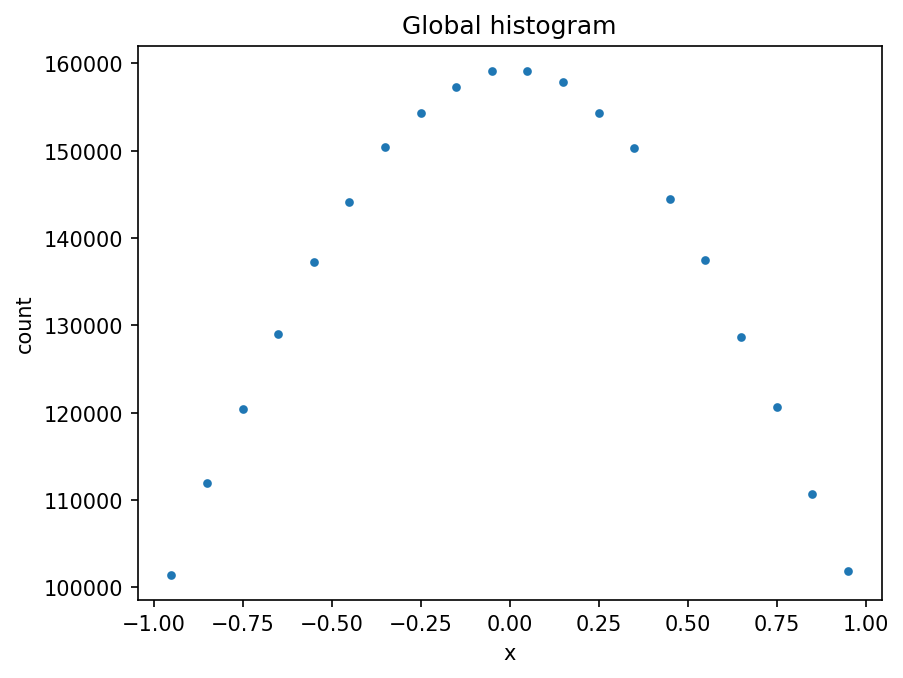

In [ ]:
from IPython.display import Image, display
display(Image("hist.png"))

#### Example 2: Distributed Matrix-Vector Multiply
* Suppose we have some big matrix $A$ and we want to compute the product
$$ y = A x $$
* We can parallelize this problem easily by breaking up $A$ into chunks row-wise, then doing matrix vector multiplications on each of the smaller matrices

In [ ]:
%%bash
cat > hello_mpi.py <<'PY'
from mpi4py import MPI
import numpy as np
import numpy.testing as npt

comm = MPI.COMM_WORLD
rank, size = comm.Get_rank(), comm.Get_size()

# global dimensions
M = 1024
rows_per_rank = M // size

# rank 0 initializes matrix/vector
if rank == 0:
    A = np.arange(M**2, dtype=np.float64).reshape(M,M)
    x = np.arange(M, dtype=np.float64)

    # Do everything on one process just so we can check our work
    y0 = A@x

else:
    A, x, y0 = None, None, None

# scatter rows of A
local_A = np.empty((rows_per_rank, M), dtype=np.float64)
comm.Scatter(A, local_A, root=0)

# broadcast x
x = comm.bcast(x, root=0)

# local matvec
y_local = local_A @ x

# gather results
y = None
if rank == 0:
    y = np.empty(M, dtype=np.float64)
comm.Gather(y_local, y, root=0)

if rank == 0:
    print("y =", y)
    print("y0=", y0 )

    npt.assert_equal(y, y0)

PY

In [ ]:
!mpiexec -n 4 python hello_mpi.py

y = [3.57389824e+08 8.93736448e+08 1.43008307e+09 ... 5.47967293e+11
 5.48503640e+11 5.49039986e+11]
y0= [3.57389824e+08 8.93736448e+08 1.43008307e+09 ... 5.47967293e+11
 5.48503640e+11 5.49039986e+11]
